In [1]:
import numpy as np
import regex as re
import pandas as pd
import pickle
from collections import defaultdict


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib import colors
from matplotlib.lines import Line2D


#from netwulf import visualize
#import netwulf as nw
#from numba import jit

#import pydot

from fa2 import ForceAtlas2
from graph_functions import create_bipartite_graph, set_politician_attributes, create_color_map
import networkx as nx
#import community for community detection
import community as community_louvain

### Goal: investigate which politicians are present the entire time for each period and establish some threshold to remove nodes that are not sufficiently present

In [2]:
#load data from df_law_clean.pickle
with open('df_law_clean.pickle', 'rb') as f:
    df = pickle.load(f)


In [3]:
df.head()

,afstemnings_id,dato_sagstrin,sag_id,titel,titel_kort,lovnummer_num,resume,periode_id,votes_adjusted,afstemnings_id_pfix,law_category_id,law_category_clean
0,2,2014-09-09T09:15:00,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '...",p2,"[33062, 33754]","[Skatter og afgifter, virksomhedsskat]"
1,4,2012-11-06T00:00:00,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,"Med loven etableres en midlertidig ordning, så...",31,"[{'id': 850407, 'typeid': 1, 'afstemningid': 4...",p4,"[62218, 34460, 33270, 33070]","[akutjob og jobpræmie til arbejdsgivere, polit..."
2,5,2014-09-09T09:15:00,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,Loven ændrer virksomhedsskatteordningens regle...,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5...",p5,"[33062, 33754]","[Skatter og afgifter, virksomhedsskat]"
3,9,2014-06-11T09:00:00,1451,Forslag til lov om ændring af lov om trafiksel...,Om Region Nordjyllands overtagelse af statens ...,136,"Med loven åbnes der mulighed for, at Region No...",32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9...",p9,"[33056, 33086]","[kollektiv transport, transportpolitik]"
4,10,2014-06-11T09:00:00,780,Forslag til lov om projektering af nyanlæg og ...,Om nyanlæg og hastighedsopgraderinger af jernb...,172,"Loven indeholder bemyndigelse til, at transpor...",32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1...",p10,"[34460, 84356, 83647, 33917, 33364]","[politisk aftale, projektering af nyanlæg og h..."


In [4]:
#take a subset of the data for period 32
df32 = df[df['periode_id'] == 32]

In [5]:
df31 = df[df['periode_id'] == 31]

In [6]:

#initialize defaultdict for politicians
dict_politicians = defaultdict()

#for each row, go through votes_adjusted and check which aktørid is in the list. If new, add to a dict of politicians, if not, add 1 to the count of that politician

for index, row in df32.iterrows():
    for vote in row['votes_adjusted']:
        if vote['aktørid'] not in dict_politicians:
            dict_politicians[vote['aktørid']] = 1
        else:
            dict_politicians[vote['aktørid']] += 1

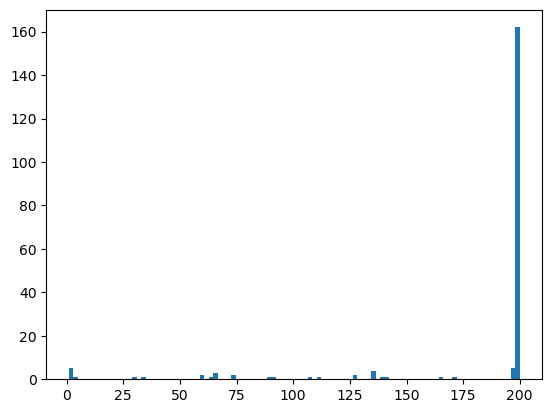

In [7]:
#make a histogram of the number of votes per politician
plt.hist(dict_politicians.values(), bins=100)
plt.show()


### The problem of politicians that have only been part of a portion of a given period - scewed data
Since we are creating a unipartite graph and relying on the weights between politicians in a given period to determine how much they collaborate, based solely on the shared amount of 'yes votes', it is a problem if we have some politicians in our dataset with very few votes in a given period. Hence, not having voting, counts equally much against being in a community with a yes voter, as simply not being present. One way to fix this, would be to set some empirical values as to influence the weight so that a yes-no vote between two politicians for the same law provides a more negative score, than a yes-absent. 

Even with weighting the vote types, we are however still faced with the problem of politicians that have less than 100% votes when including both yes, no, absent and blank votes. This could happen if there was some mistake in the registration of votes, but will certaintly happen when a politician due to serius sickness, maternity leave, quitting etc. is no longer part of the parlaimentary work, or when a substitution enters in midst of a period. If we include politicians that for whatever reason may just have participated in some % of the votings that year, we expect that this wil scew our community detection significantly as the weights will make it appear as if this person disagree with the majority of the other politicians that they in fact agreed with (given that much fewer edges will be created for a politician that did fewer votings). 

A solution would be to scale the weight of the edges in a network, based on the % of total votings they have been part of in that given period (including both absent, blank, yes and no votes), or simply remove politicians that have only been partially involved in the votings for a given year (perhaps at some reasonable threshold).

### Removing politicians that have not participated in the majorty of votings
We decided to proceed with the approach of removing politicians

In [8]:
#after having check a few periods, it seems to make sense to make a threshold at 90% of max votes
threshold = 0.9 * max(dict_politicians.values())

In [9]:
#This function takes a periode_id and calculates the 90% threshold for that period
def threshold_periode(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return 0.9 * max(dict_politicians.values())


In [10]:
#This function takes a periode_id and returns a list of politicians who have voted more than 90% of the time
def active_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    threshold = 0.9 * max(dict_politicians.values())

    return [key for key, value in dict_politicians.items() if value > threshold]

In [11]:
#This function does the same as above, but without the threshold
def all_politicians(periode_id):
    df_periode = df[df['periode_id'] == periode_id]
    dict_politicians = defaultdict()
    for index, row in df_periode.iterrows():
        for vote in row['votes_adjusted']:
            if vote['aktørid'] not in dict_politicians:
                dict_politicians[vote['aktørid']] = 1
            else:
                dict_politicians[vote['aktørid']] += 1
    return [key for key, value in dict_politicians.items()]

In [12]:
#We find all unique periode_ids
periode_ids = df['periode_id'].unique()

#We make a dict of active politicians for each periode_id
dict_active_politicians = defaultdict()
for periode_id in periode_ids:
    dict_active_politicians[periode_id] = active_politicians(periode_id)


In [13]:
#We make a new pandas dataframe, where we go through votes_adjusted and only keep the votes from active politicians
df_active = pd.DataFrame(columns=['periode_id', 'votes_adjusted'])
for index, row in df.iterrows():
    votes_adjusted = row['votes_adjusted']
    votes_adjusted = [vote for vote in votes_adjusted if vote['aktørid'] in dict_active_politicians[row['periode_id']]]
    df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2555559439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_active = df_active.append({'periode_id': row['periode_id'], 'votes_adjusted': votes_adjusted}, ignore_index=True)
C:\Users\rune7\AppData\Local\Temp\ipykernel

In [14]:
df_active.head()

,periode_id,votes_adjusted
0,32,"[{'id': 180, 'typeid': 1, 'afstemningid': 2, '..."
1,31,"[{'id': 850408, 'typeid': 1, 'afstemningid': 4..."
2,32,"[{'id': 164665, 'typeid': 1, 'afstemningid': 5..."
3,32,"[{'id': 163591, 'typeid': 4, 'afstemningid': 9..."
4,32,"[{'id': 163770, 'typeid': 1, 'afstemningid': 1..."


In [15]:
#Initialize defaultdict for politicians
politicians_lost = defaultdict()
politicians_active = defaultdict()

for period in periode_ids:
    #Number of politicans who voted in each vote
    all_pol = all_politicians(period)
    active_pol = active_politicians(period)
    politicians_lost[period] = len(all_pol) - len(active_pol)
    politicians_active[period] = len(active_pol)


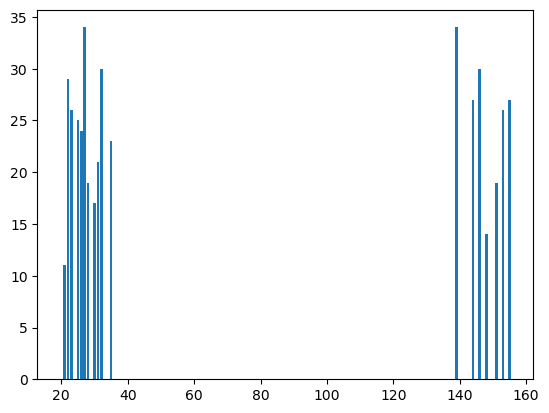

The average number of politicians dropped per period is 19.818181818181817


In [16]:
#Make a histogram of the number of politicians lost per period with periode_id as x-axis
plt.bar(politicians_lost.keys(), politicians_lost.values())
plt.show()
print('The average number of politicians dropped per period is', np.mean(list(politicians_lost.values())))

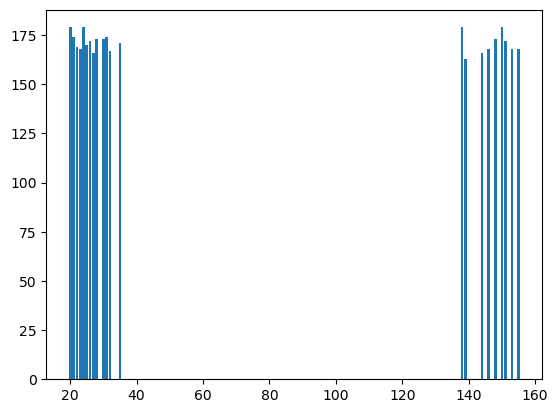

The average number of politicians that we consider per period is 171.4090909090909


In [17]:
#Make a histogram of the number of active politicians with periode_id as x-axis
plt.bar(politicians_active.keys(), politicians_active.values())
plt.show()
print('The average number of politicians that we consider per period is', np.mean(list(politicians_active.values())))

Given that there are at any time 179 politicians in the parlaiment, we believe that by sorting off less than 8 politicians pr. period on average, our data analysis will still be representative. 

In [19]:
#append a column to df from df_active, where we have the votes_adjusted from df_active
df['votes_adjusted_active'] = df_active['votes_adjusted']


In [25]:
#pickle the new dataframe
#with open('df_law_active.pickle', 'wb') as f:
#    pickle.dump(df, f)

#load data from df_law_active.pickle
with open('df_law_active.pickle', 'rb') as f:
    df = pickle.load(f)

In [26]:
#create a networkx graph for period 32
df32 = df[df['periode_id'] == 32]

G = create_bipartite_graph(df32)

#set attributes for politicians
G = set_politician_attributes(G)

In [27]:
#Function to check for isolate nodes
def remove_isolate_nodes(G):
    isolate_nodes = list(nx.isolates(G))
    if len(isolate_nodes) > 0:
        G.remove_nodes_from(isolate_nodes)
        print(f'Removed {len(isolate_nodes)} isolate nodes')
    else:
        print('No isolate nodes')
    return G

In [28]:
#clean graph
#remove the isolated nodes
remove_isolate_nodes(G)

law_nodes, politician_nodes = nx.bipartite.sets(G)

color_map = create_color_map() #defined in graph_functions.py

No isolate nodes


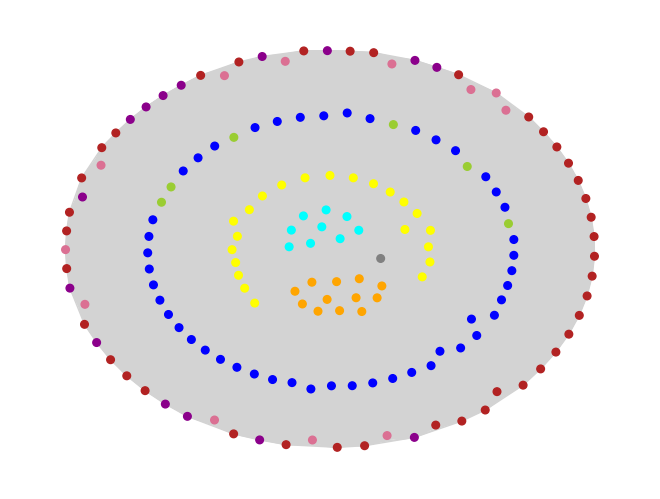

In [29]:
G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

pos = nx.kamada_kawai_layout(G_uni)
#pos = nx.fruchterman_reingold_layout(G_uni, k=0.5, iterations=50)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()])

In [30]:
#Do clustering on the graph using the Louvain algorithm
partition = community_louvain.best_partition(G_uni)

#print number of clusters
print(len(set(partition.values())))


3


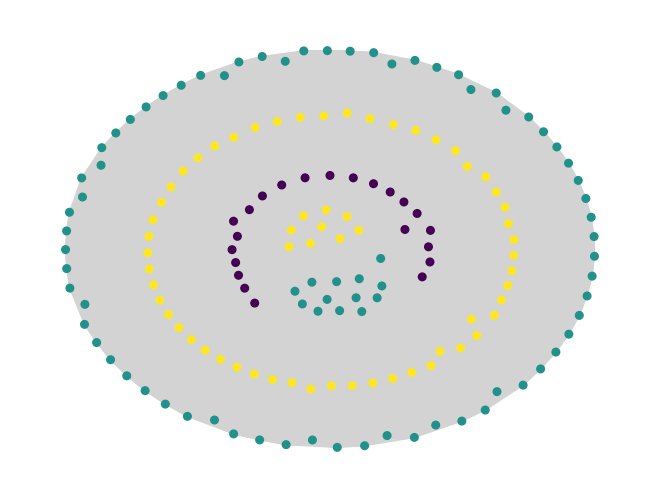

In [31]:
#plot the graph with the clusters
pos = nx.kamada_kawai_layout(G_uni)

nx.draw(G_uni, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()])
plt.show()

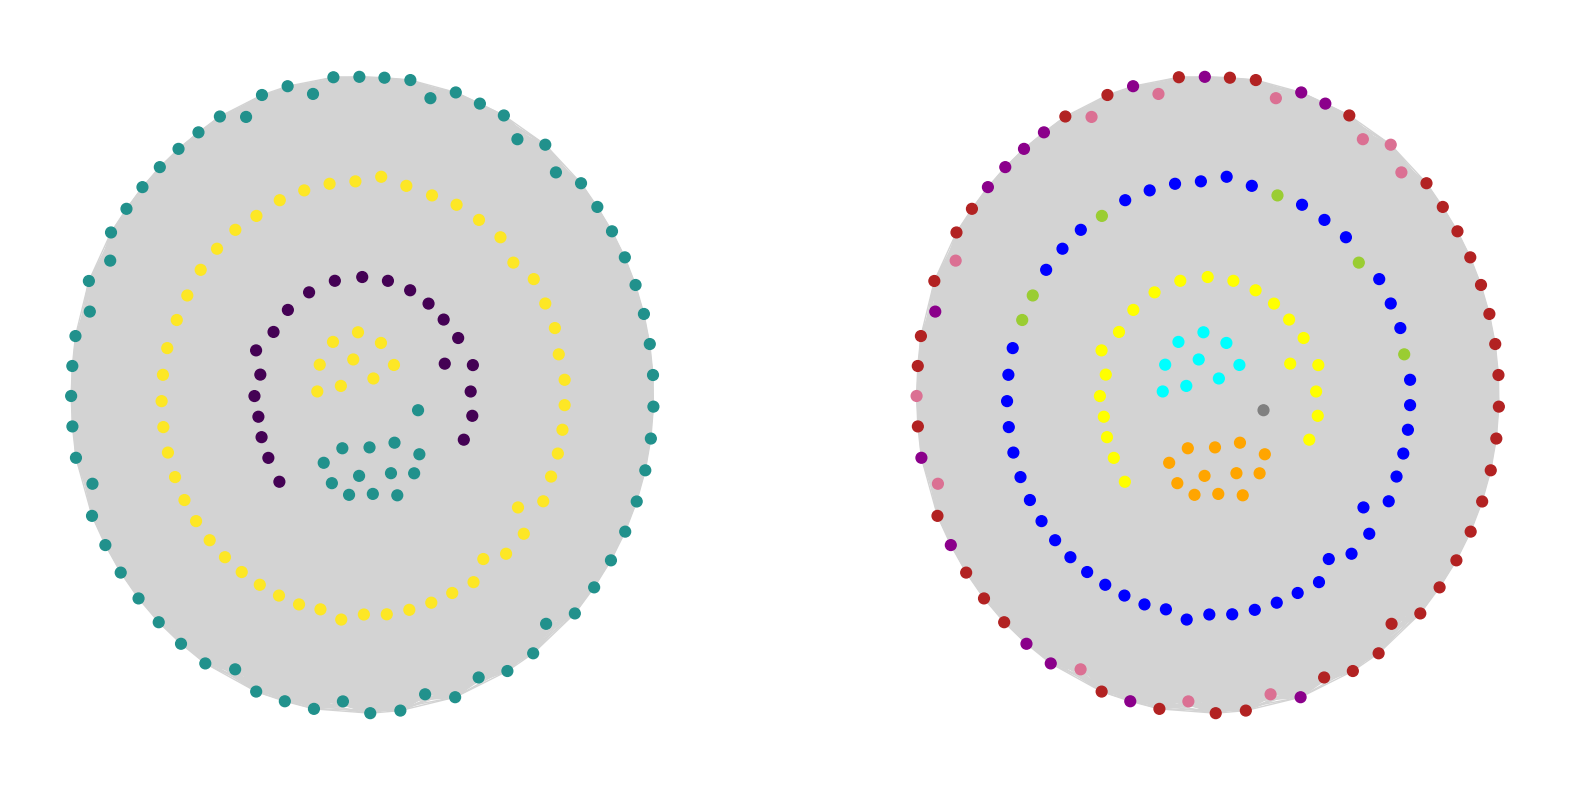

In [32]:
#plot the graph with the clusters in a subgraph
#two horizontally stacked subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#plot the networkx graph in ax1 
pos = nx.kamada_kawai_layout(G_uni, weight='weight', scale=100)
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_uni.nodes()], ax=ax1)
#plot it with party colors
nx.draw(G_uni, node_size = 60, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_uni.nodes[node]['color'] for node in G_uni.nodes()], ax=ax2)

In [34]:
#Who is the grey (out of folketingsgruppe) politician?
for node in G_uni.nodes():
    if G_uni.nodes[node]['color'] == 'grey':
        #print name attribute of the node
        print(G_uni.nodes[node]['name'])

Uffe Elbæk


In [35]:
#Uffe Elbæk left radikale venstre in 2013, and this period covers 2014-2015 - makes sense.

In [36]:
#import backbone
import backbone_network as bb

#make a backbone network
G_backbone = bb.get_graph_backbone(G_uni, 0.5)


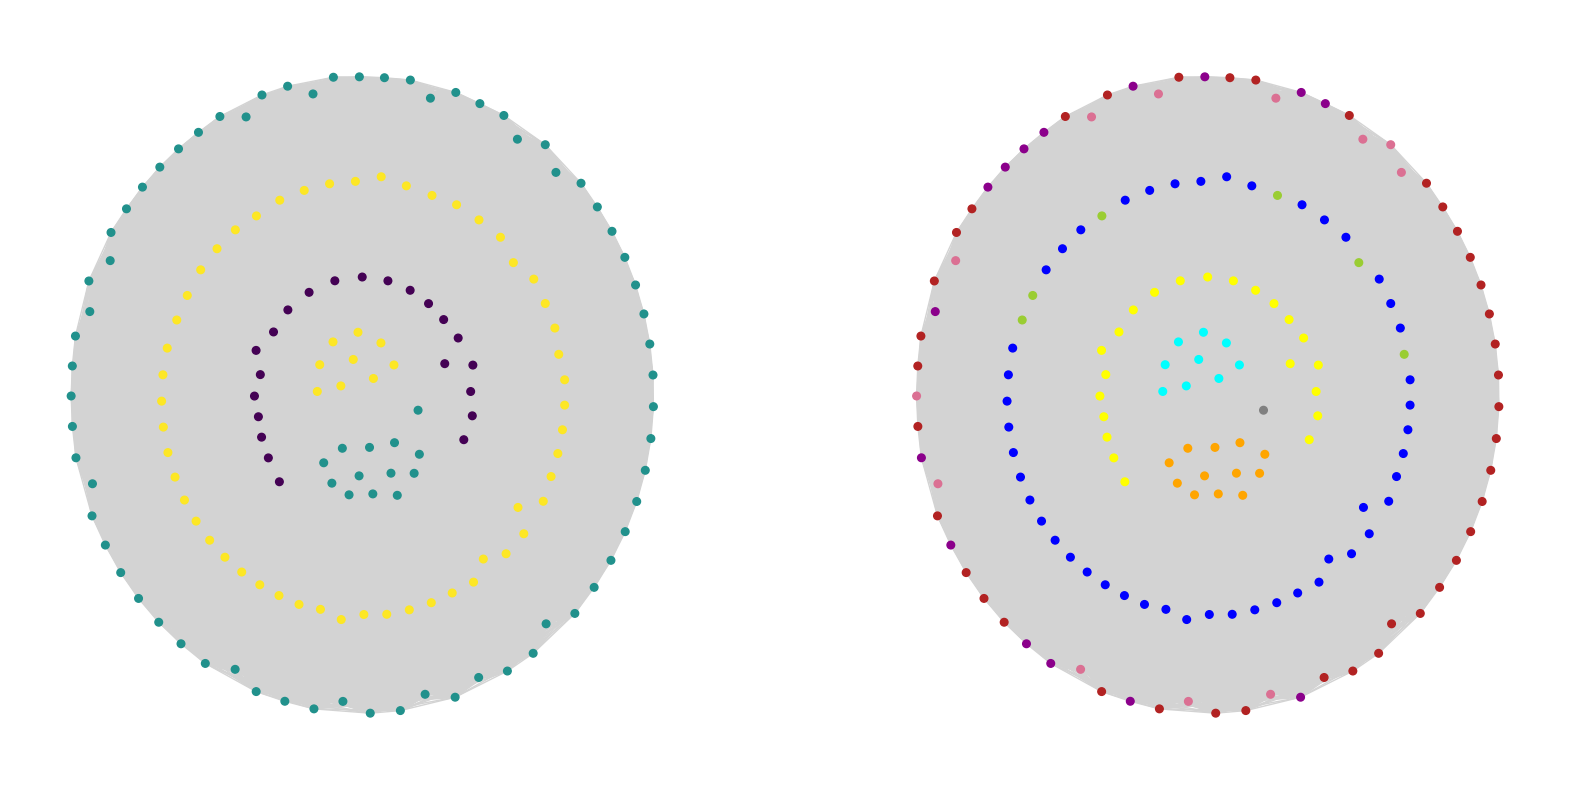

In [37]:
#plot the backbone network
pos = nx.kamada_kawai_layout(G_backbone, weight='weight', scale=100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
nx.draw(G_backbone, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [partition[node] for node in G_backbone.nodes()], ax=ax1)
nx.draw(G_backbone, node_size = 30, with_labels = False, pos=pos, edge_color = '#d3d3d3', node_color = [G_backbone.nodes[node]['color'] for node in G_backbone.nodes()], ax=ax2)


### We first plot the clustering over time for each period and check if the same parties are in the same clusters and if certain individuals are not in the same cluster as their party

In [91]:
#loading politician info from pickle politician_df_clean.pkl
with open('politician_df_clean.pkl', 'rb') as f:
    politician_df = pickle.load(f)

politician_df.head()

#set the index to politician_id
politician_df = politician_df.set_index('politician_id')

c:\Users\rune7\anaconda3\envs\css\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [97]:
for id in partition.keys():
    #check that the politician_id is in the politician_df
    if id in politician_df.index:
        pass
    else:
        print(id)

In [125]:
len(df)

3762

In [126]:
#some entries for period 155 have nan values. We get rid of them
df = df.dropna()
len(df)

3696

In [127]:
#We make a dict where we have the periode_id as key and the aktør_id with their party and partition as value
partition_all_periods = pd.DataFrame()

#unique periods
periods = df['periode_id'].unique()

trouble_ids = []

for periode_id in periods:
    print(f'Working on periode_id {periode_id}')

    #get the df for the periode_id
    df_period = df[df['periode_id'] == periode_id]

    G = create_bipartite_graph(df_period)

    #set attributes for politicians
    G = set_politician_attributes(G)

    #clean graph
    #remove the isolated nodes
    remove_isolate_nodes(G)
    
    law_nodes, politician_nodes = nx.bipartite.sets(G)

    color_map = create_color_map() #defined in graph_functions.py

    G_uni = nx.bipartite.weighted_projected_graph(G, politician_nodes)

    #Do clustering on the graph using the Louvain algorithm
    partition = community_louvain.best_partition(G_uni)

    
    period_dict = defaultdict()
    for id in partition.keys():
        try:
            #get party of id
            party = politician_df.loc[id]['party'][periode_id]
            period_dict[id] = [party, partition[id],periode_id]
            period_df = pd.DataFrame.from_dict(period_dict, orient='index', columns=['party', 'partition', 'periode_id'])
        except KeyError:
            trouble_ids.append({'id':id, 'periode_id':periode_id})
            print(f'KeyError for id {id} and periode_id {periode_id}')
            pass

    
    partition_all_periods = partition_all_periods.append(period_df)



Working on periode_id 32
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 31
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 30
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 28
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 35
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 27
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 138
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 139
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 144
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 146
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 26
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 24
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 25
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 23
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 22
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 21
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 20
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 148
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 150
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 151
No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


Working on periode_id 153
No isolate nodes
KeyError for id 19809 and periode_id 153
Working on periode_id 155


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


No isolate nodes


C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2114448701.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  partition_all_periods = partition_all_periods.append(period_df)


In [138]:
#We check which partition people from socialdemokratiet are in
partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].value_counts('partition')

#This means we have to change it such that the partition number is consistent across periods

#First we find out which partitition number is most common for socialdemokratiet for each period
soc_partition = partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].groupby('periode_id').agg(lambda x:x.value_counts().index[0])

In [140]:
#For all periods where the partition number is not 0, we change it to 0 and we change the partition number for the other parties accordingly
for periode_id in soc_partition.index:
    #get subset of partition_all_periods for the periode_id
    df_period = partition_all_periods[partition_all_periods['periode_id'] == periode_id]
    #get the partition number for socialdemokratiet
    soc_partition_number = soc_partition.loc[periode_id]['partition']
    #if the partition number is not 0, we change it to 0
    if soc_partition_number != 0:
        #We first move all the parities with soc_partition_number to partition 10 (which is not used)
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == soc_partition_number), 'partition'] = 10
        #We then move all the parties with partition number 0 to soc_partition_number
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == 0), 'partition'] = soc_partition_number
        #We then move all the parties with partition number 10 to 0
        partition_all_periods.loc[(partition_all_periods['periode_id'] == periode_id) & (partition_all_periods['partition'] == 10), 'partition'] = 0

In [142]:
#We check that it worked
partition_all_periods[partition_all_periods['party'] == 'Socialdemokratiet'].value_counts('partition')
#This means that two persons from Socialdemokratiet were not assigned to the same parititon as the rest of the party

#We figure out which two persons it is and when they were in the party
partition_all_periods[(partition_all_periods['party'] == 'Socialdemokratiet') & (partition_all_periods['partition'] != 0)]

,party,partition,periode_id
16503,Socialdemokratiet,2,153
152,Socialdemokratiet,2,153


In [143]:
#We see who the non-conformers are
politician_df.loc[partition_all_periods[(partition_all_periods['party'] == 'Socialdemokratiet') & (partition_all_periods['partition'] != 0)].index]

,politician_name,party
16503,Anne Paulin,"{139: 'Socialdemokratiet', 150: 'Socialdemokra..."
152,Ida Auken,"{32: 'Socialistisk Folkeparti', 31: 'Socialist..."


In [145]:
#This function finds non-conformers for all parties for all periods
def find_non_conformers(partition_all_periods):
    non_conformers = pd.DataFrame()
    parties = partition_all_periods['party'].unique()
    for party in parties:
        #get subset of partition_all_periods for the party
        df_party = partition_all_periods[partition_all_periods['party'] == party]
        #get the partition number for the party for each period
        periods = df_party['periode_id'].unique()
        for period in periods:
            #get subset of partition_all_periods for the party and period
            df_period = df_party[df_party['periode_id'] == period]
            #get the partition number for the party
            party_partition_number = df_period['partition'].unique()[0]
            #get the subset of partition_all_periods for the party and period where the partition number is not the same as the party
            non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
    return non_conformers

non_conformers = find_non_conformers(partition_all_periods)

C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2197451279.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2197451279.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2197451279.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_conformers = non_conformers.append(df_period[df_period['partition'] != party_partition_number])
C:\Users\rune7\AppData\Local\Temp\ipykernel_19388\2197451279.py:16: FutureWarning: The fram

In [149]:
#We add the politician name to the non_conformers
for id in non_conformers.index:
    non_conformers.loc[id, 'politician_name'] = politician_df.loc[id]['politician_name']
non_conformers

,party,partition,periode_id,politician_name
44,Enhedslisten,2,153,Henning Hyllested
16503,Socialdemokratiet,2,153,Anne Paulin
152,Socialdemokratiet,2,153,Ida Auken
19637,"Venstre, Danmarks Liberale Parti",2,153,Kenneth Mikkelsen
19807,"Venstre, Danmarks Liberale Parti",2,153,Anne Rasmussen
18701,"Venstre, Danmarks Liberale Parti",2,153,Marie Bjerre
219,Socialistisk Folkeparti,2,153,Lisbeth Bech-Nielsen
4969,Radikale Venstre,1,25,Jørgen Poulsen
18728,Radikale Venstre,2,153,Anne Sophie Callesen
17141,Det Konservative Folkeparti,2,153,Brigitte Klintskov Jerkel


In [136]:
#

,party,partition
periode_id,,
20,9,2
21,10,2
22,7,2
23,10,2
24,4,1
25,11,2
26,13,2
27,11,2
28,12,2


0      [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...
2      [{'id': 164665, 'typeid': 1, 'afstemningid': 5...
3      [{'id': 163591, 'typeid': 4, 'afstemningid': 9...
4      [{'id': 163770, 'typeid': 1, 'afstemningid': 1...
5      [{'id': 163949, 'typeid': 1, 'afstemningid': 1...
                             ...                        
214    [{'id': 756629, 'typeid': 2, 'afstemningid': 4...
215    [{'id': 756808, 'typeid': 1, 'afstemningid': 4...
216    [{'id': 756987, 'typeid': 1, 'afstemningid': 4...
217    [{'id': 757166, 'typeid': 1, 'afstemningid': 4...
218    [{'id': 757345, 'typeid': 1, 'afstemningid': 4...
Name: votes_adjusted_active, Length: 200, dtype: object

In [122]:
#count nan values

df155['votes_adjusted_active'].isna().sum()

66

In [124]:
df155

,afstemnings_id,dato_sagstrin,sag_id,titel,titel_kort,lovnummer_num,resume,periode_id,votes_adjusted,afstemnings_id_pfix,law_category,law_category_id,law_category_clean,votes_adjusted_active
3600,8377,2021-10-14T00:00:00,89639,Forslag til lov om ændring af lov om rentefrie...,Om udskydelse af tilbagebetalingsfrister for l...,9,Med lovforslaget foreslås det som det første a...,155,"[{'id': 1940431, 'typeid': 1, 'afstemningid': ...",p8377,"[Skatter og afgifter 15, Skatter og afgifter 5...","[34105, 33487, 85017]","[Skatter og afgifter, Skatter og afgifter, COV...","[{'id': 1966028, 'typeid': 1, 'afstemningid': ..."
3601,8382,2021-11-09T00:00:00,89627,Forslag til lov om ændring af lov om Digital P...,Om omstillingsperiode ved overgang til en ny d...,3,Med lovforslaget ønsker man at sikre hjemmel t...,155,"[{'id': 1941326, 'typeid': 1, 'afstemningid': ...",p8382,"[Biblioteker og museer 14, digitalisering]","[35213, 34050]","[Biblioteker og museer, digitalisering]","[{'id': 1966207, 'typeid': 1, 'afstemningid': ..."
3602,8383,2021-11-09T00:00:00,89661,Forslag til lov om ændring af lov om folkeskol...,Om håndtering af faglige udfordringer som følg...,35,Formålet med lovforslaget er at give større fr...,155,"[{'id': 1941505, 'typeid': 1, 'afstemningid': ...",p8383,"[Undervisningsvæsen 1A, folkeskolen]","[33762, 33318]","[Undervisningsvæsen, folkeskolen]","[{'id': 1966386, 'typeid': 1, 'afstemningid': ..."
3603,8384,2021-11-09T00:00:00,89637,Forslag til lov om ændring af lov om social pe...,Om særlig adgang til oplysninger fra Rigsarkiv...,17,"Lovforslaget indebærer, at ansøgere til tidlig...",155,"[{'id': 1941684, 'typeid': 1, 'afstemningid': ...",p8384,"[Forsikringsvæsen 3, folkepension og førtidspe...","[33274, 33071]","[Forsikringsvæsen, folkepension og førtidspens...","[{'id': 1966565, 'typeid': 1, 'afstemningid': ..."
3604,8385,2021-11-11T00:00:00,90209,Forslag til lov om ændring af lov om dansk ind...,Om adgang for børn af dansksindede sydslesvige...,42,"Regeringspartiet Socialdemokratiet, Venstre, D...",155,"[{'id': 1942579, 'typeid': 1, 'afstemningid': ...",p8385,[indfødsretsprøve],[35371],[indfødsretsprøve],"[{'id': 1966744, 'typeid': 1, 'afstemningid': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,8994,2022-09-22T00:00:00,93092,Forslag til lov om ændring af lov om leje og l...,Om loft over huslejestigninger som følge af ud...,210,Lovforslaget udmønter aftalen om initiativer t...,155,"[{'id': 2065373, 'typeid': 1, 'afstemningid': ...",p8994,"[Bygningsvæsen 21, boligpolitik]","[33271, 33362]","[Bygningsvæsen, boligpolitik]",NaN
3824,8997,2022-09-29T00:00:00,93164,Forslag til lov om ændring af lov om fremme af...,Om udvidelse af muligheden for at støtte initi...,211,"Lovens formål foreslås udvidet, så der bliver ...",155,"[{'id': 2065910, 'typeid': 2, 'afstemningid': ...",p8997,"[Elektriske anlæg 10, Skatter og afgifter 78, ...","[34104, 33060, 33466]","[Elektriske anlæg, Skatter og afgifter, energi...",NaN
3825,8998,2022-09-29T00:00:00,93182,Forslag til lov om en indefrysningsordning for...,Om en indefrysningsordning for høje energiregn...,212,Forslaget etablerer en frivillig og midlertidi...,155,"[{'id': 2066089, 'typeid': 2, 'afstemningid': ...",p8998,"[Elektriske anlæg 6, Finansvæsen 22, energifor...","[34103, 33739, 33466]","[Elektriske anlæg, Finansvæsen, energiforsyning]",NaN
3826,8999,2022-09-29T00:00:00,93180,Forslag til lov om likviditetslån m.v. i forbi...,Om likviditetslån til høje energiregninger.,213,"Lovforslaget tilvejebringer hjemmel til, at Er...",155,"[{'id': 2066268, 'typeid': 2, 'afstemningid': ...",p8999,"[Finansvæsen 12, konkurrence- og forbrugerforh...","[85365, 33084]","[Finansvæsen, konkurrence- og forbrugerforhold]",NaN


In [123]:
#get the politician_ids with nan values
df155[df155['votes_adjusted_active'].isna()]['aktør_id']

KeyError: 'aktør_id'

In [114]:
df[df['periode_id'] == 155]

,afstemnings_id,dato_sagstrin,sag_id,titel,titel_kort,lovnummer_num,resume,periode_id,votes_adjusted,afstemnings_id_pfix,law_category,law_category_id,law_category_clean,votes_adjusted_active
3600,8377,2021-10-14T00:00:00,89639,Forslag til lov om ændring af lov om rentefrie...,Om udskydelse af tilbagebetalingsfrister for l...,9,Med lovforslaget foreslås det som det første a...,155,"[{'id': 1940431, 'typeid': 1, 'afstemningid': ...",p8377,"[Skatter og afgifter 15, Skatter og afgifter 5...","[34105, 33487, 85017]","[Skatter og afgifter, Skatter og afgifter, COV...","[{'id': 1966028, 'typeid': 1, 'afstemningid': ..."
3601,8382,2021-11-09T00:00:00,89627,Forslag til lov om ændring af lov om Digital P...,Om omstillingsperiode ved overgang til en ny d...,3,Med lovforslaget ønsker man at sikre hjemmel t...,155,"[{'id': 1941326, 'typeid': 1, 'afstemningid': ...",p8382,"[Biblioteker og museer 14, digitalisering]","[35213, 34050]","[Biblioteker og museer, digitalisering]","[{'id': 1966207, 'typeid': 1, 'afstemningid': ..."
3602,8383,2021-11-09T00:00:00,89661,Forslag til lov om ændring af lov om folkeskol...,Om håndtering af faglige udfordringer som følg...,35,Formålet med lovforslaget er at give større fr...,155,"[{'id': 1941505, 'typeid': 1, 'afstemningid': ...",p8383,"[Undervisningsvæsen 1A, folkeskolen]","[33762, 33318]","[Undervisningsvæsen, folkeskolen]","[{'id': 1966386, 'typeid': 1, 'afstemningid': ..."
3603,8384,2021-11-09T00:00:00,89637,Forslag til lov om ændring af lov om social pe...,Om særlig adgang til oplysninger fra Rigsarkiv...,17,"Lovforslaget indebærer, at ansøgere til tidlig...",155,"[{'id': 1941684, 'typeid': 1, 'afstemningid': ...",p8384,"[Forsikringsvæsen 3, folkepension og førtidspe...","[33274, 33071]","[Forsikringsvæsen, folkepension og førtidspens...","[{'id': 1966565, 'typeid': 1, 'afstemningid': ..."
3604,8385,2021-11-11T00:00:00,90209,Forslag til lov om ændring af lov om dansk ind...,Om adgang for børn af dansksindede sydslesvige...,42,"Regeringspartiet Socialdemokratiet, Venstre, D...",155,"[{'id': 1942579, 'typeid': 1, 'afstemningid': ...",p8385,[indfødsretsprøve],[35371],[indfødsretsprøve],"[{'id': 1966744, 'typeid': 1, 'afstemningid': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3823,8994,2022-09-22T00:00:00,93092,Forslag til lov om ændring af lov om leje og l...,Om loft over huslejestigninger som følge af ud...,210,Lovforslaget udmønter aftalen om initiativer t...,155,"[{'id': 2065373, 'typeid': 1, 'afstemningid': ...",p8994,"[Bygningsvæsen 21, boligpolitik]","[33271, 33362]","[Bygningsvæsen, boligpolitik]",NaN
3824,8997,2022-09-29T00:00:00,93164,Forslag til lov om ændring af lov om fremme af...,Om udvidelse af muligheden for at støtte initi...,211,"Lovens formål foreslås udvidet, så der bliver ...",155,"[{'id': 2065910, 'typeid': 2, 'afstemningid': ...",p8997,"[Elektriske anlæg 10, Skatter og afgifter 78, ...","[34104, 33060, 33466]","[Elektriske anlæg, Skatter og afgifter, energi...",NaN
3825,8998,2022-09-29T00:00:00,93182,Forslag til lov om en indefrysningsordning for...,Om en indefrysningsordning for høje energiregn...,212,Forslaget etablerer en frivillig og midlertidi...,155,"[{'id': 2066089, 'typeid': 2, 'afstemningid': ...",p8998,"[Elektriske anlæg 6, Finansvæsen 22, energifor...","[34103, 33739, 33466]","[Elektriske anlæg, Finansvæsen, energiforsyning]",NaN
3826,8999,2022-09-29T00:00:00,93180,Forslag til lov om likviditetslån m.v. i forbi...,Om likviditetslån til høje energiregninger.,213,"Lovforslaget tilvejebringer hjemmel til, at Er...",155,"[{'id': 2066268, 'typeid': 2, 'afstemningid': ...",p8999,"[Finansvæsen 12, konkurrence- og forbrugerforh...","[85365, 33084]","[Finansvæsen, konkurrence- og forbrugerforhold]",NaN


In [106]:
#convert to dataframe
period_df = pd.DataFrame.from_dict(period_dict, orient='index', columns=['party', 'partition', 'periode_id'])
period_df

,party,partition,periode_id
5,Enhedslisten,1,32
12,Socialdemokratiet,1,32
17,Socialdemokratiet,1,32
18,Dansk Folkeparti,0,32
23,Socialdemokratiet,1,32
...,...,...,...
297,Socialdemokratiet,1,32
352,Socialdemokratiet,1,32
364,"Venstre, Danmarks Liberale Parti",2,32
365,"Venstre, Danmarks Liberale Parti",2,32


In [74]:
len(politician_df[politician_df['politician_id'] == 20144]['party'])

1